<h3>Bayesiansk inferens - ett exempel</h3>
Den här notebooken beskriver ett enkelt exempel på bayesiansk inferens, utifrån data samplat från vårt pingvin-dataset. Vi gör en enkel modell för att ta fram en sannolikhetsfördelning för medelvärdet på pingvinernas kroppsvikt.<br><br>
Mycket av innehållet är baserat på den <a href=https://towardsdatascience.com/how-to-use-bayesian-inference-for-predictions-in-python-4de5d0bc84f3>här bloggposten</a>.<br><br>

Först importerar vi paket och data som vanligt.

In [13]:
#Importera nödvändiga paket oc rådata
import numpy as np
import pandas as pd

from scipy.stats import uniform
from scipy.stats import norm
from scipy import integrate

import seaborn as sns
import matplotlib.pyplot as plt

# importera palmer penguins
filepath = '/Users/joeloscarsson/Documents/www/Statistics/Data/penguins.csv'
penguins = pd.read_csv(filepath)
penguins = penguins.dropna().reset_index() # Plocka bort rader som innehåller NaN

Sedan förbereder vi våra iterationsparametrar, där <code>obs_n</code> är antalet iterationer, och <code>obs_m</code> är antalet observationer i varje iteration. Vi skapar också en tom lista <code>obs_list</code> där vi kan spara alla observationer.

In [14]:
# Preparing variables
obs_n = 20 # Number of observations
obs_m = 5 # Number of values in one observation

obs_list = list() # Create list of observations

Här genererar vi våra observationer genom att slumpmässigt dra kroppsvikter från vår population.

In [15]:
# Iterate over obs_n to create rvs-observations
for n in np.arange(1,obs_n):
    obs = penguins['body_mass_g'].sample(obs_m)
    obs_list.append(obs) # Append current observaiton to obs_list

Vi definierar sedan en likelihood-funktion. Vi gissar här att data kommer vara normalfördelat, och låter därför vår likelihood-funktion vara en normalfördelning med en standardavvikelse på 800 (känt från populationsdata). Likelihood-funktionen beräknar medelvärdet i en observation, och beräknar utifrån det en sannolikhet m.h.a. täthetsfunktion för normalfördelningen <code>norm.pdf()</code>.

In [16]:
# Define Likelihood function
def likelihood_fun(data, mu):
    data = data.mean()
    result = norm.pdf(data, mu, scale=penguins['body_mass_g'].std()) # Compute probability density from observed mean using SciPy.stats.norm
    return result # Return result

## Var på medelvärde my befinner vi oss med vårt nuvaranda dataset

Här skapar vi x-data för våra fördelningar. Vi gör en numpy-array med värden där vi tror att vårt medelvärde är inkluderat. Vi skapar också en prior distribution och låter den vara en uniform fördelning över hela x-axeln. Det här är en s.k. non-informative prior, den är alltså inte viktad åt något håll.


x-data i detta fallet är våra gissningar på mu.

In [17]:
mu = np.linspace(2000, 8000, num=500) # Create 'mu' as x-axis
prior = uniform.pdf(mu) + 1 # Define prior function as a non-informative uniform distribution

Här skapar vi en lista att spara vår posterior i när vi itererar. Det här är mest för att kunna göra en snygg plott över processen efteråt.

In [18]:
# Initialize empty lists to save posterior and prior distributions
posterior_plot = list()

Här är själva iterations-processen. Vi loopar över alla observationer i vår lista <code>obs_list</code>. Genom att använda <code>enumerate()</code> får vi automatiskt ett index för varje iteration.

Vi evaluerar först likelihood för vår observation över hela x-axeln, sedan multiplicerar vi den med vår prior. Detta ger oss en icke-normerad version av vår posterior. För att normera posterior dividerar vi den med dess integral, m.h.a. <code>integrate.trapz()</code>.

Slutligen lägger vi till ett if-villkor som sparar vår posterior vid var 5:e iteration, så vi kan plotta processen efteråt.

In [26]:
# Iterate over list of observations to make bayesian inference
for iter, obs in enumerate(obs_list):
    
    likelihood_out = likelihood_fun(obs, mu) # Evaluate likelihood function for observed data

    unnormalized_posterior = likelihood_out * prior # Create posterior distribution from likelihood * prior
    # Vi har inte dividerat med sannolikheten D än.  

    # Normalize posterior distribution by integrated unnormalized posterior
    posterior = unnormalized_posterior / integrate.trapz(unnormalized_posterior, mu)
    # Här normerar vi

    if iter % round(obs_n/5) == 0:
        posterior_plot.append(posterior) # Append every 5th posterior to posterior_plot
        
    prior = posterior # Set current posterior as new prior

Här skapar vi en Pandas-df med alla våra sparade posteriors, vi adderar sedan vår x-axel 'mu' m.h.a. <code>insert()</code>. För att göra plottandet lite enklare gör vi en <code>melt()</code> på vår df.

In [20]:
df = pd.DataFrame(data=posterior_plot) # Create df from resulting posterior distributions
df = df.transpose() # Transpose df

df.insert(0, 'mu', mu) # Insert mu as x-axis in posterior df
df = df.melt('mu', var_name='Iterations', value_name='vals') # Melt df for convenient plotting

Här gör vi en plot över våra sparade posteriors. Vi bygger själva plotten med Seaborn, och justerar lite utseendeparametrar efteråt.

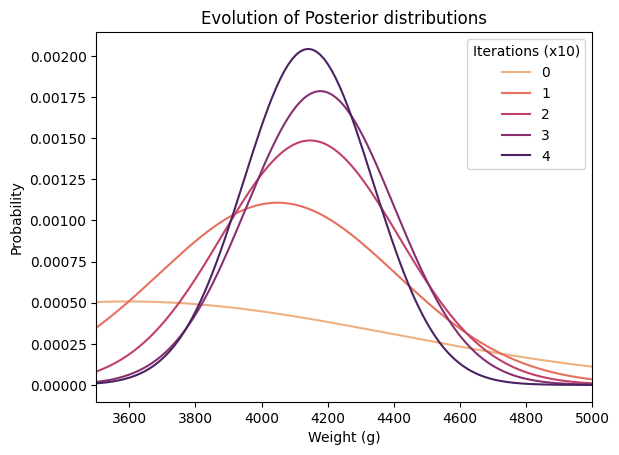

In [27]:
#Create Seaborn lineplot of posterior distributions
ax = sns.lineplot(data=df, x='mu', y='vals', hue='Iterations', palette='flare')
ax.set_title('Evolution of Posterior distributions')
ax.set(xlabel='Weight (g)', ylabel='Probability')
ax.legend(title='Iterations (x10)')
ax.set_xlim(3500,5000)
plt.show()

Härnäst börjar vi skapa ett 95% credible interval för vårt medelvärde. Vi börjar med att beräkna en kumulativ fördelningsfunktion för vår posterior m.h.a. <code>integrate.cumtrapz()</code>. Sedan undersöker vi utseendet på den med en simpel plot.

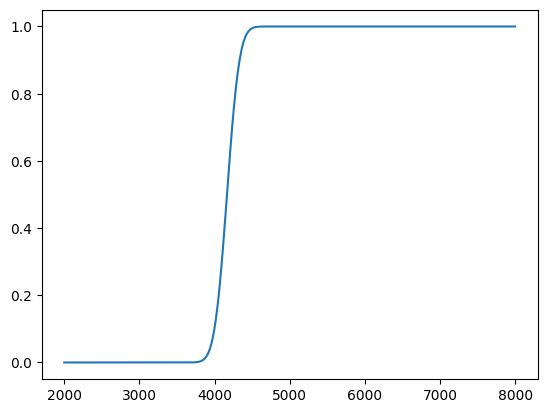

In [31]:
posterior_cdf = integrate.cumtrapz(posterior, mu, initial=0)

plt.plot(mu,posterior_cdf)

Nästa steg är att ta fram x-värden för vårt 95% CI. Vi använder oss av <code>np.searchsorted()</code> för att ta fram index för vilka $cdf(X\leq alpha, 1-alpha$). Sedan letar vi upp deras motsvarande x-värden i 'mu' och sparar dem som 'CI_lower' och CI_upper'.

In [23]:
alpha = 0.05

CI_lower = mu[np.searchsorted(posterior_cdf, alpha/2)]
CI_upper = mu[np.searchsorted(posterior_cdf, 1-alpha/2)]

CI_lower,CI_upper

(3803.6072144288573, 4537.074148296593)

Slutligen plottar vi vår posterior fördelning tillsammans med två axvlines som representerar gränserna för vårt CI.

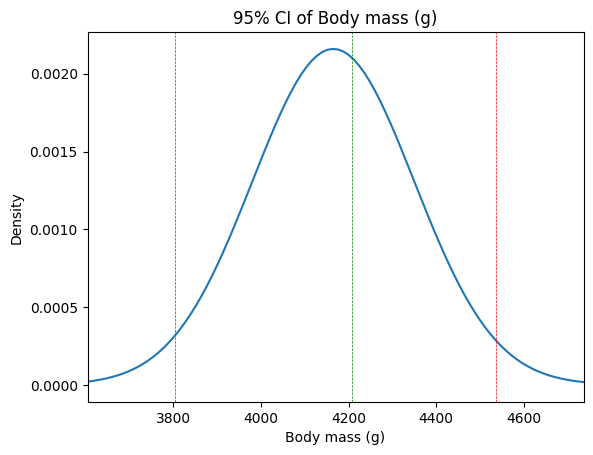

In [24]:
#Create Seaborn lineplot of posterior distributions
ax = sns.lineplot(x=mu, y=posterior)
ax.set_title('95% CI of Body mass (g)')
ax.set(ylabel='Density', xlabel='Body mass (g)')
ax.set_xlim(CI_lower-200,CI_upper+200)
ax.axvline(CI_lower, c='r', linestyle='--', linewidth=0.5)
ax.axvline(CI_upper, c='r', linestyle='--', linewidth=0.5)
ax.axvline(np.mean(penguins['body_mass_g']), c='g', linestyle='--', linewidth=0.5)
plt.show()

# Det gröna är det teoretiska värdet på var medelpopulationen kommer ifrån

In [25]:
print('CI (95%) of penguin body mass from bayesian inference model: '+ str(round(CI_lower,1))+' - '+str(round(CI_upper,1)))

CI (95%) of penguin body mass from bayesian inference model: 3803.6 - 4537.1
